This notebook is used to generate Figure 5 in the paper.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import logging
from typing import Dict

from depsurf import FuncGroup, FuncGroups, InlineType, Version
from utils import OUTPUT_PATH


def count_inline(v: Version):
    groups = FuncGroups.from_dump(v.func_groups_path)
    results: Dict[InlineType, Dict[str, FuncGroup]] = {t: {} for t in InlineType}

    for group in groups.iter_groups():
        results[group.inline_type][group.name] = group

    output_path = OUTPUT_PATH / "inline" / v.name
    output_path.mkdir(parents=True, exist_ok=True)
    for t, group in results.items():
        path = output_path / f"{t.name.lower()}.txt"
        with open(path, "w") as f:
            for group in results[t].values():
                for func in group.funcs:
                    lines = (
                        f"{func.name}",
                        f"\tLoc: {func.loc}",
                        f"\tFile: {func.file}",
                        f"\tInline: {func.inline}",
                        f"\tExternal: {func.external}",
                        f"\tCaller Inline ({len(func.caller_inline)})",
                        *(f"\t\t{caller}" for caller in func.caller_inline),
                        f"\tCaller Func ({len(func.caller_func)})",
                        *(f"\t\t{caller}" for caller in func.caller_func),
                    )
                    print("\n".join(lines), file=f)
        logging.info(f"Saved {len(results[t]):5} groups to {path}")

    return {t: len(d) / groups.num_groups for t, d in results.items()}


# count_inline(VERSION_LAST)

In [3]:
from depsurf import VersionGroup, Version
from utils import save_pkl
from typing import Dict

groups = [VersionGroup.REGULAR, VersionGroup.ARCH]

DataType = Dict[VersionGroup, Dict[Version, Dict[InlineType, float]]]
data: DataType = {}
for group in groups:
    group_data = {}
    for version in group.versions:
        group_data[version] = count_inline(version)
    data[group] = group_data

save_pkl(data, "inline")

[       groups.py:45 ] INFO: Loading funcs from /users/szhong/DepSurf/data/func_groups/4.4.0-21-generic-amd64.jsonl
[   3289530486.py:34 ] INFO: Saved 31197 groups to /users/szhong/DepSurf/output/inline/4.4.0-21-generic-amd64/not.txt
[   3289530486.py:34 ] INFO: Saved 19900 groups to /users/szhong/DepSurf/output/inline/4.4.0-21-generic-amd64/full.txt
[   3289530486.py:34 ] INFO: Saved  6306 groups to /users/szhong/DepSurf/output/inline/4.4.0-21-generic-amd64/partial.txt
[       groups.py:45 ] INFO: Loading funcs from /users/szhong/DepSurf/data/func_groups/4.8.0-22-generic-amd64.jsonl
[   3289530486.py:34 ] INFO: Saved 32826 groups to /users/szhong/DepSurf/output/inline/4.8.0-22-generic-amd64/not.txt
[   3289530486.py:34 ] INFO: Saved 20945 groups to /users/szhong/DepSurf/output/inline/4.8.0-22-generic-amd64/full.txt
[   3289530486.py:34 ] INFO: Saved  6610 groups to /users/szhong/DepSurf/output/inline/4.8.0-22-generic-amd64/partial.txt
[       groups.py:45 ] INFO: Loading funcs from /u

In [4]:
import pandas as pd

from utils import load_pkl

data: "DataType" = load_pkl("inline")
pd.DataFrame(
    {
        (group, version): data[group][version]
        for group in data
        for version in data[group]
    }
).T

[ utils_pickle.py:18 ] INFO: Loding inline from /users/szhong/DepSurf/output/inline.pkl


Not inlined  Fully inlined  Partially inlined
Regular 4.4.0-21-generic-amd64       0.543473       0.346672           0.109855
        4.8.0-22-generic-amd64       0.543648       0.346881           0.109472
        4.10.0-19-generic-amd64      0.542314       0.348975           0.108711
        4.13.0-16-generic-amd64      0.534523       0.350582           0.114896
        4.15.0-20-generic-amd64      0.536402       0.348616           0.114983
        4.18.0-10-generic-amd64      0.547821       0.350536           0.101643
        5.0.0-13-generic-amd64       0.545583       0.354027           0.100390
        5.3.0-18-generic-amd64       0.548839       0.353256           0.097905
        5.4.0-26-generic-amd64       0.547360       0.354456           0.098184
        5.8.0-25-generic-amd64       0.568490       0.327451           0.104059
        5.11.0-16-generic-amd64      0.576946       0.322732           0.100322
        5.13.0-19-generic-amd64      0.555827       0.347098           0.097075
        5.15.0-25-generic-amd64      0.556735       0.348744           0.094521
        5.19.0-21-generic-amd64      0.561719       0.349475           0.088806
        6.2.0-20-generic-amd64       0.558719       0.353250           0.088030
        6.5.0-9-generic-amd64        0.560868       0.350575           0.088557
        6.8.0-31-generic-amd64       0.560232       0.350305           0.089463
Arch    5.4.0-26-generic-arm64       0.552155       0.350248           0.097597
        5.4.0-26-generic-armhf       0.567610       0.344633           0.087757
        5.4.0-26-generic-ppc64el     0.554854       0.355316           0.089830
        5.4.0-24-generic-riscv64     0.535947       0.366581           0.097472

[ utils_pickle.py:18 ] INFO: Loding inline from /users/szhong/DepSurf/output/inline.pkl


[utils_matplotlib.py:82 ] INFO: Saved figure to /users/szhong/DepSurf/paper/figs/inline.pdf


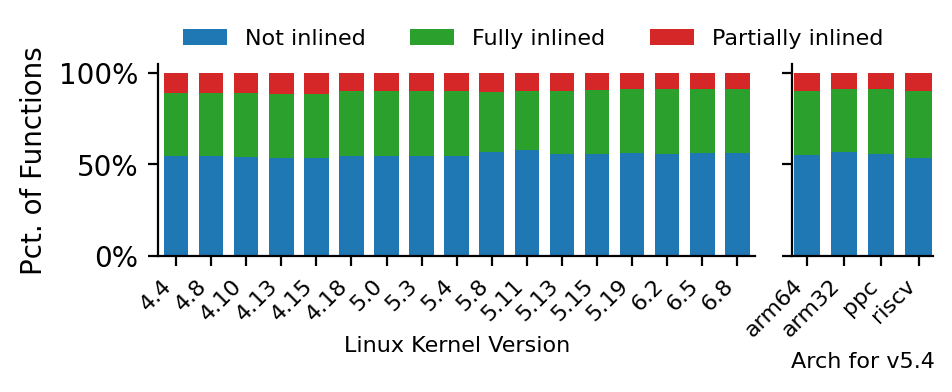

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter

from depsurf import InlineType, VersionGroup
from utils import get_legend_handles_labels, load_pkl, save_fig, ARCH_NAMES

data: "DataType" = load_pkl("inline")

COLORS = {
    InlineType.NOT: "tab:blue",
    InlineType.FULL: "tab:green",
    InlineType.PARTIAL: "tab:red",
}

GROUPS = {
    VersionGroup.REGULAR: "Linux Kernel Version",
    VersionGroup.ARCH: "Arch for v5.4",
}

fig, axs = plt.subplots(
    1,
    len(data),
    figsize=(5, 1.25),
    sharey=True,
    width_ratios=[len(v) for v in data.values()],
    gridspec_kw={"wspace": 0.1},
)

for group_idx, (ax, (group, group_data)) in enumerate(zip(axs, data.items())):
    for i, (version, version_data) in enumerate(group_data.items()):
        bottom = 0
        for k, v in version_data.items():
            ax.bar(i, v, 0.7, label=k, bottom=bottom, color=COLORS[k])
            bottom += v

    if group == VersionGroup.REGULAR:
        labels = [v.short_version for v in group_data]
    elif group == VersionGroup.ARCH:
        labels = [ARCH_NAMES[v.arch] for v in group_data]

    ax.set_xticks(np.arange(len(labels)), labels)
    ax.set_xlabel(GROUPS[group], fontsize=8)
    ax.set_xticklabels(labels, fontsize=8, rotation=45, ha="right", va="top")

    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0%}"))

axs[0].set_ylabel("Pct. of Functions")

handles, labels = get_legend_handles_labels(fig)
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=5,
    bbox_to_anchor=(0.5, 1.1),
    fontsize=8,
)

save_fig(fig, "inline")